<a href="https://colab.research.google.com/github/megha1627/skarlapa_MachineLearning/blob/main/AML_ASSIGNMENT_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c dogs-vs-cats

100% 810M/812M [00:35<00:00, 24.6MB/s]
100% 812M/812M [00:35<00:00, 23.9MB/s]


In [5]:
!unzip -qq dogs-vs-cats.zip

In [6]:
!unzip -qq test1.zip

In [7]:
!unzip -qq train.zip

Question1.
Consider the Cats & Dogs example. Start initially with a training sample of 1000, a validation sample of 500, and a test sample of 500 (like in the text). Use any technique to reduce overfitting and improve performance in developing a network that you train from scratch. What performance did you achieve? Copying images to training, validation, and test directories.

In [8]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
#Initially taking 1000 samples for training set
make_subset("train", start_index=0, end_index=1000)
#500 samples for validation set
make_subset("validation", start_index=1000, end_index=1500)
#500 for test set
make_subset("test", start_index=1500, end_index=2000)

Data preprocessing

Using image_dataset_from_directory to read images

In [9]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [10]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [11]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [12]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [13]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


In [14]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


Building the model

In [15]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [16]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

Fitting the model using a Dataset

In [18]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 17s 86ms/step - loss: 0.6973 - accuracy: 0.5015 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 2/30
63/63 [==============================] - 4s 61ms/step - loss: 0.6937 - accuracy: 0.5160 - val_loss: 0.6949 - val_accuracy: 0.5000
Epoch 3/30
63/63 [==============================] - 6s 84ms/step - loss: 0.6887 - accuracy: 0.5325 - val_loss: 0.8265 - val_accuracy: 0.5000
Epoch 4/30
63/63 [==============================] - 4s 63ms/step - loss: 0.6704 - accuracy: 0.6080 - val_loss: 0.6766 - val_accuracy: 0.5810
Epoch 5/30
63/63 [==============================] - 5s 80ms/step - loss: 0.6376 - accuracy: 0.6420 - val_loss: 0.5993 - val_accuracy: 0.6750
Epoch 6/30
63/63 [==============================] - 4s 60ms/step - loss: 0.6130 - accuracy: 0.6720 - val_loss: 0.6030 - val_accuracy: 0.6700
Epoch 7/30
63/63 [==============================] - 4s 63ms/step - loss: 0.5727 - accuracy: 0.7000 - val_loss: 1.1431 - val_accuracy: 0.5100
Epoch 8/30
6

Displaying curves of loss and accuracy during training

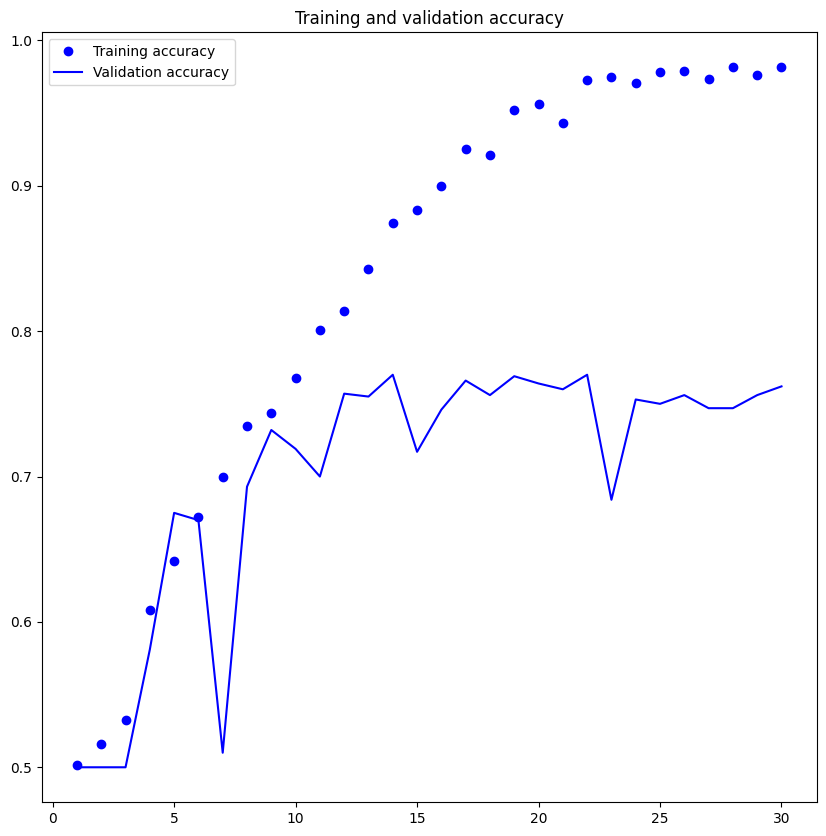

<Figure size 640x480 with 0 Axes>

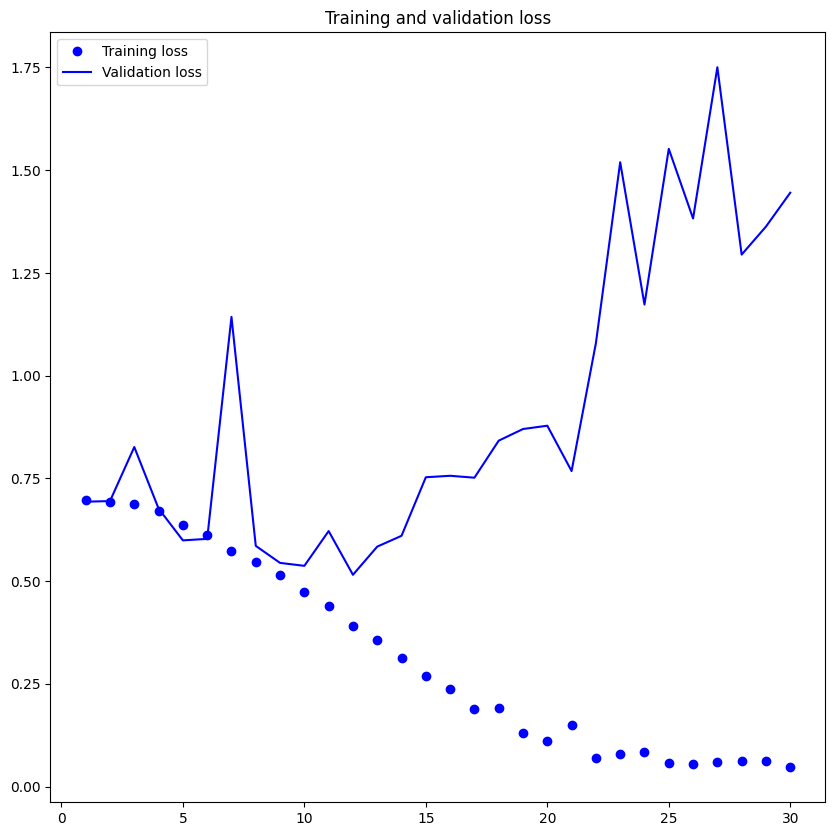

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.figure(figsize=(10,10))
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Evaluating the model on the test set

In [20]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")   

32/32 [==============================] - 3s 54ms/step - loss: 0.5584 - accuracy: 0.7290
Test accuracy: 0.729


we got training accurracy as 97.95%, validation accuracy as 76.1% and test accuracy 72.1%

Question 2
Increase your training sample size. You may pick any amount. Keep the validation and test samples the same as above. Optimize your network (again training from scratch). What performance did you achieve?

Using data augmentation

Define a data augmentation stage to add to an image model

In [21]:
import os, shutil, pathlib

shutil.rmtree("./cats_vs_dogs_small_Q2", ignore_errors=True)

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_Q2")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
#Here I have increased training sample size to 1500 and keeping the validation and test sample size to 500 each as before
make_subset("train", start_index=0, end_index=1500)
make_subset("validation", start_index=1500, end_index=2000)
make_subset("test", start_index=2000, end_index=2500)
     

In [22]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

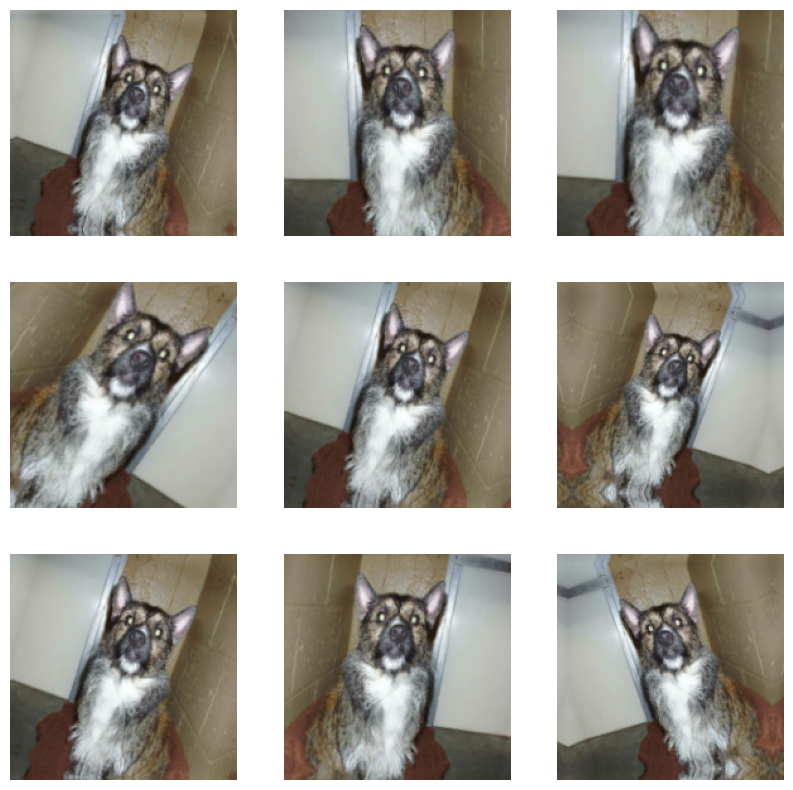

In [23]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

Defining a new convnet that includes image augmentation and dropout

In [24]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

Training the regularized convnet

In [25]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset,
    callbacks=callbacks)
     

Epoch 1/20
63/63 [==============================] - 6s 64ms/step - loss: 0.7086 - accuracy: 0.4980 - val_loss: 0.6927 - val_accuracy: 0.5010
Epoch 2/20
63/63 [==============================] - 5s 77ms/step - loss: 0.6942 - accuracy: 0.5010 - val_loss: 0.6924 - val_accuracy: 0.5280
Epoch 3/20
63/63 [==============================] - 4s 62ms/step - loss: 0.6940 - accuracy: 0.5075 - val_loss: 0.6924 - val_accuracy: 0.5010
Epoch 4/20
63/63 [==============================] - 4s 61ms/step - loss: 0.7065 - accuracy: 0.5325 - val_loss: 0.6966 - val_accuracy: 0.5080
Epoch 5/20
63/63 [==============================] - 5s 82ms/step - loss: 0.6862 - accuracy: 0.5685 - val_loss: 0.7036 - val_accuracy: 0.5380
Epoch 6/20
63/63 [==============================] - 4s 62ms/step - loss: 0.6775 - accuracy: 0.6045 - val_loss: 0.6670 - val_accuracy: 0.5700
Epoch 7/20
63/63 [==============================] - 4s 62ms/step - loss: 0.6650 - accuracy: 0.6095 - val_loss: 0.6409 - val_accuracy: 0.6330
Epoch 8/20
63

Evaluating the model on the test set



In [26]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 29ms/step - loss: 0.5791 - accuracy: 0.7020
Test accuracy: 0.702


Question 3
Now change your training sample so that you achieve better performance than those from Steps 1 and 2. This sample size may be larger, or smaller than those in the previous steps. The objective is to find the ideal training sample size to get best prediction results.

In [27]:
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_Q3")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
#As increasing the sample size is always good than decreasing, here we're increasing the training the sample size to 2000
make_subset("train", start_index=0, end_index=2000)
#validation and test sample size 500 each
make_subset("validation", start_index=2000, end_index=2500)
make_subset("test", start_index=2500, end_index=3000)

In [28]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [29]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation1.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 9s 81ms/step - loss: 0.6980 - accuracy: 0.5035 - val_loss: 0.6919 - val_accuracy: 0.5390
Epoch 2/20
63/63 [==============================] - 4s 62ms/step - loss: 0.6961 - accuracy: 0.5055 - val_loss: 0.6928 - val_accuracy: 0.5000
Epoch 3/20
63/63 [==============================] - 5s 72ms/step - loss: 0.6906 - accuracy: 0.5185 - val_loss: 0.6817 - val_accuracy: 0.5420
Epoch 4/20
63/63 [==============================] - 4s 62ms/step - loss: 0.6871 - accuracy: 0.5405 - val_loss: 0.6672 - val_accuracy: 0.6130
Epoch 5/20
63/63 [==============================] - 5s 76ms/step - loss: 0.6921 - accuracy: 0.5065 - val_loss: 0.6885 - val_accuracy: 0.5000
Epoch 6/20
63/63 [==============================] - 4s 62ms/step - loss: 0.6737 - accuracy: 0.5785 - val_loss: 0.6524 - val_accuracy: 0.5910
Epoch 7/20
63/63 [==============================] - 4s 63ms/step - loss: 0.6697 - accuracy: 0.5950 - val_loss: 0.6362 - val_accuracy: 0.6550
Epoch 8/20
63

In [30]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation1.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")


32/32 [==============================] - 1s 29ms/step - loss: 0.5101 - accuracy: 0.7480
Test accuracy: 0.748


Question 4
Repeat Steps 1-3, but now using a pretrained network. The sample sizes you use in Steps 2 and 3 for the pretrained network may be the same or different from those using the network where you trained from scratch. Again, use any and all optimization techniques to get best performance.

Leveraging a pretrained model

Feature extraction with a pretrained model

Instantiating the VGG16 convolutional base

In [31]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 3s 0us/step


In [32]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

Fast feature extraction without data augmentation





Extracting the VGG16 features and corresponding labels

In [33]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 18ms/step


In [34]:
train_features.shape

(2000, 5, 5, 512)

Defining and training the densely connected classifier

In [35]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 1s 9ms/step - loss: 19.4421 - accuracy: 0.9250 - val_loss: 3.0481 - val_accuracy: 0.9740
Epoch 2/20
63/63 [==============================] - 0s 5ms/step - loss: 3.0047 - accuracy: 0.9785 - val_loss: 7.3398 - val_accuracy: 0.9560
Epoch 3/20
63/63 [==============================] - 0s 5ms/step - loss: 2.2113 - accuracy: 0.9830 - val_loss: 5.0731 - val_accuracy: 0.9640
Epoch 4/20
63/63 [==============================] - 0s 6ms/step - loss: 1.9192 - accuracy: 0.9885 - val_loss: 3.1804 - val_accuracy: 0.9800
Epoch 5/20
63/63 [==============================] - 0s 6ms/step - loss: 0.5398 - accuracy: 0.9940 - val_loss: 2.5737 - val_accuracy: 0.9790
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 1.4062 - accuracy: 0.9900 - val_loss: 2.2839 - val_accuracy: 0.9850
Epoch 7/20
63/63 [==============================] - 0s 5ms/step - loss: 0.3375 - accuracy: 0.9945 - val_loss: 3.2643 - val_accuracy: 0.9830
Epoch 8/20
63/63 [=

Plotting the results

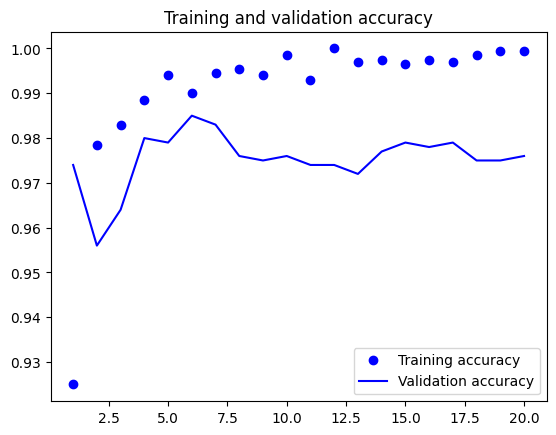

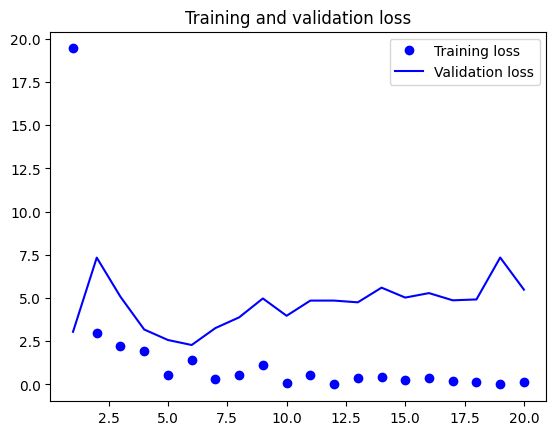

In [36]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Feature extraction together with data augmentation.

Instantiating and freezing the VGG16 convolutional base

In [40]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

Printing the list of trainable weights before and after freezing

In [41]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [42]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


Adding a data augmentation stage and a classifier to the convolutional base

In [43]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [44]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
63/63 [==============================] - 11s 152ms/step - loss: 23.3899 - accuracy: 0.8885 - val_loss: 4.2210 - val_accuracy: 0.9660
Epoch 2/10
63/63 [==============================] - 12s 179ms/step - loss: 6.2749 - accuracy: 0.9525 - val_loss: 5.2767 - val_accuracy: 0.9700
Epoch 3/10
63/63 [==============================] - 9s 141ms/step - loss: 5.8810 - accuracy: 0.9540 - val_loss: 7.0743 - val_accuracy: 0.9700
Epoch 4/10
63/63 [==============================] - 9s 140ms/step - loss: 5.1121 - accuracy: 0.9580 - val_loss: 5.4230 - val_accuracy: 0.9680
Epoch 5/10
63/63 [==============================] - 11s 174ms/step - loss: 4.3790 - accuracy: 0.9680 - val_loss: 4.7510 - val_accuracy: 0.9800
Epoch 6/10
63/63 [==============================] - 9s 144ms/step - loss: 5.6826 - accuracy: 0.9580 - val_loss: 3.8007 - val_accuracy: 0.9780
Epoch 7/10
63/63 [==============================] - 9s 140ms/step - loss: 1.9802 - accuracy: 0.9770 - val_loss: 4.3063 - val_accuracy: 0.9750
Ep

Evaluating the model on the test set

In [45]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 3s 91ms/step - loss: 4.6457 - accuracy: 0.9730
Test accuracy: 0.973


Fine-tuning a pretrained model


In [46]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

Freezing all layers until the fourth from the last

In [47]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

Fine-tuning the model

In [48]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
63/63 [==============================] - 15s 172ms/step - loss: 2.6793 - accuracy: 0.9765 - val_loss: 2.5908 - val_accuracy: 0.9770
Epoch 2/10
63/63 [==============================] - 12s 193ms/step - loss: 1.0075 - accuracy: 0.9810 - val_loss: 2.6667 - val_accuracy: 0.9780
Epoch 3/10
63/63 [==============================] - 13s 198ms/step - loss: 1.2689 - accuracy: 0.9820 - val_loss: 2.3518 - val_accuracy: 0.9780
Epoch 4/10
63/63 [==============================] - 11s 170ms/step - loss: 0.8031 - accuracy: 0.9860 - val_loss: 2.2122 - val_accuracy: 0.9770
Epoch 5/10
63/63 [==============================] - 10s 157ms/step - loss: 0.7982 - accuracy: 0.9860 - val_loss: 2.6803 - val_accuracy: 0.9740
Epoch 6/10
63/63 [==============================] - 10s 158ms/step - loss: 0.7579 - accuracy: 0.9865 - val_loss: 2.5664 - val_accuracy: 0.9750
Epoch 7/10
63/63 [==============================] - 10s 161ms/step - loss: 0.6155 - accuracy: 0.9885 - val_loss: 2.4945 - val_accuracy: 0.9710

In [49]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 3s 91ms/step - loss: 2.0709 - accuracy: 0.9780
Test accuracy: 0.978
